
Training: Logistic Regression
F2 Score on held-out eval set: 0.6091
              precision    recall  f1-score   support

           0       0.66      0.82      0.73      6132
           1       0.76      0.58      0.66      6132

    accuracy                           0.70     12264
   macro avg       0.71      0.70      0.70     12264
weighted avg       0.71      0.70      0.70     12264



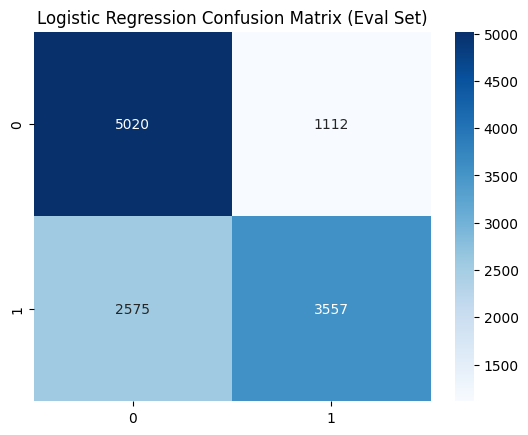


Training: Decision Tree
F2 Score on held-out eval set: 0.8002
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      6132
           1       0.78      0.80      0.79      6132

    accuracy                           0.79     12264
   macro avg       0.79      0.79      0.79     12264
weighted avg       0.79      0.79      0.79     12264



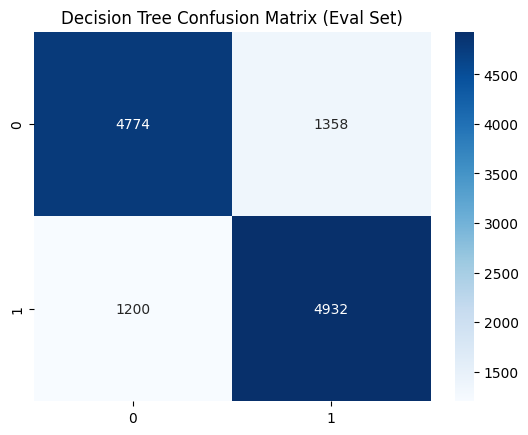


Training: Random Forest
F2 Score on held-out eval set: 0.8635
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      6132
           1       0.89      0.86      0.87      6132

    accuracy                           0.87     12264
   macro avg       0.87      0.87      0.87     12264
weighted avg       0.87      0.87      0.87     12264



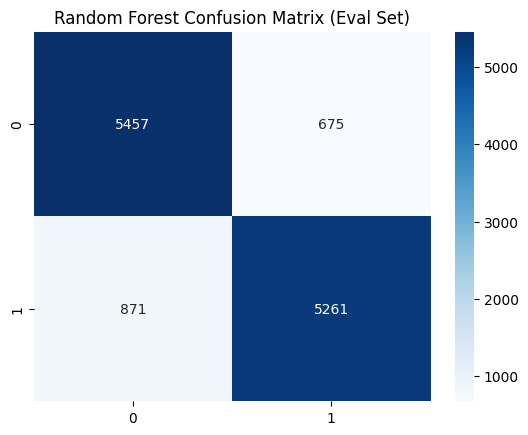


Training: XGBoost


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:10:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F2 Score on held-out eval set: 0.8559
              precision    recall  f1-score   support

           0       0.85      0.92      0.89      6132
           1       0.92      0.84      0.88      6132

    accuracy                           0.88     12264
   macro avg       0.89      0.88      0.88     12264
weighted avg       0.89      0.88      0.88     12264



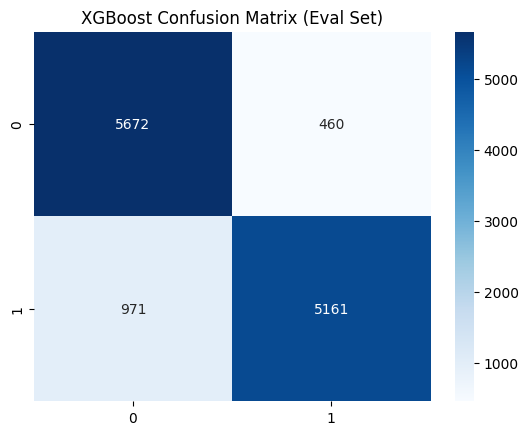


 Best model: RandomForestClassifier with F2 score: 0.8635
Submission saved: submission_YourEnrollmentNumber.csv


In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import fbeta_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


train_df = pd.read_csv('/content/train_dataset_final1.csv')
valid_df = pd.read_csv('/content/validate_dataset_final.csv')


def add_features(df):
    df['credit_util_ratio'] = df['AVG_Bill_amt'] / (df['LIMIT_BAL'] + 1)
    df['pay_amt_sum'] = df[[f'pay_amt{i}' for i in range(1,7)]].sum(axis=1)
    df['bill_amt_sum'] = df[[f'Bill_amt{i}' for i in range(1,7)]].sum(axis=1)
    df['delinquency_streak'] = df[['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']].apply(lambda row: sum(row >= 1), axis=1)
    return df

train_df = add_features(train_df)
valid_df = add_features(valid_df)

X_train = train_df.drop(columns=['Customer_ID', 'next_month_default'])
y_train = train_df['next_month_default']
X_valid = valid_df.drop(columns=['Customer_ID'])


imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

X_train = imputer.fit_transform(X_train)
X_valid = imputer.transform(X_valid)

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)


X_train_sub, X_eval, y_train_sub, y_eval = train_test_split(
    X_train_bal, y_train_bal, test_size=0.3, random_state=42, stratify=y_train_bal
)


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

best_f2 = 0
best_model = None

for name, model in models.items():
    print(f"\nTraining: {name}")
    model.fit(X_train_sub, y_train_sub)

    y_pred = model.predict(X_eval)

    f2 = fbeta_score(y_eval, y_pred, beta=2)
    print(f"F2 Score on held-out eval set: {f2:.4f}")
    print(classification_report(y_eval, y_pred))

    cm = confusion_matrix(y_eval, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix (Eval Set)")
    plt.show()

    if f2 > best_f2:
        best_f2 = f2
        best_model = model

print(f"\n Best model: {type(best_model).__name__} with F2 score: {best_f2:.4f}")

best_model.fit(X_train_bal, y_train_bal)


y_pred_valid = best_model.predict(X_valid_scaled)

submission = pd.DataFrame({
    'Customer': valid_df['Customer_ID'],
    'next_month_default': y_pred_valid
})
submission.to_csv('submission_YourEnrollmentNumber.csv', index=False)
print("Submission saved: submission_YourEnrollmentNumber.csv")



Training Logistic Regression...
Logistic Regression F2 Score: 0.6091
Training Decision Tree...
Decision Tree F2 Score: 0.8002
Training Random Forest...
Random Forest F2 Score: 0.8635
Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:21:26] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost F2 Score: 0.8559


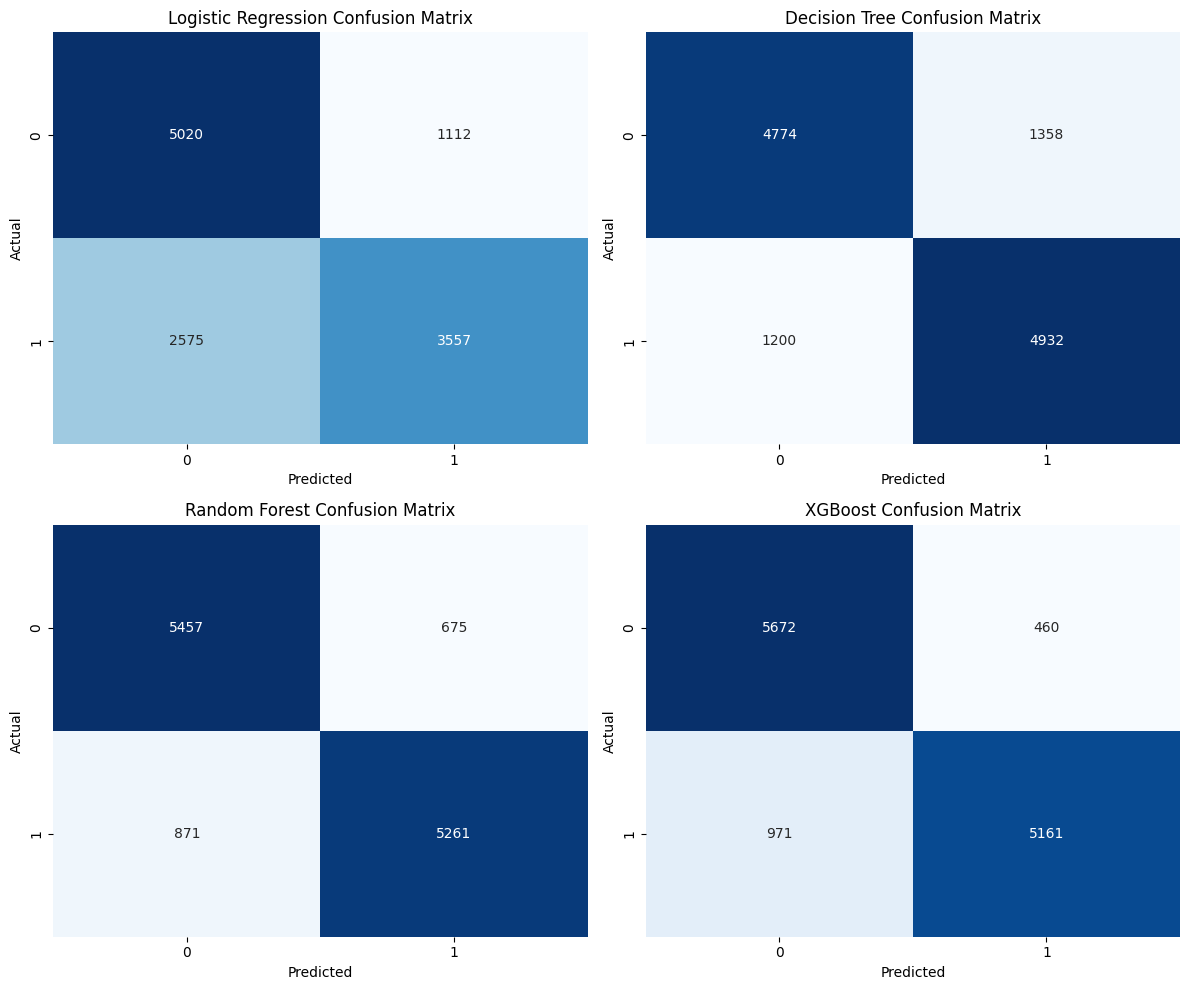

<ipython-input-12-3424457545>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_f2_scores.values()), y=list(model_f2_scores.keys()), palette='viridis')


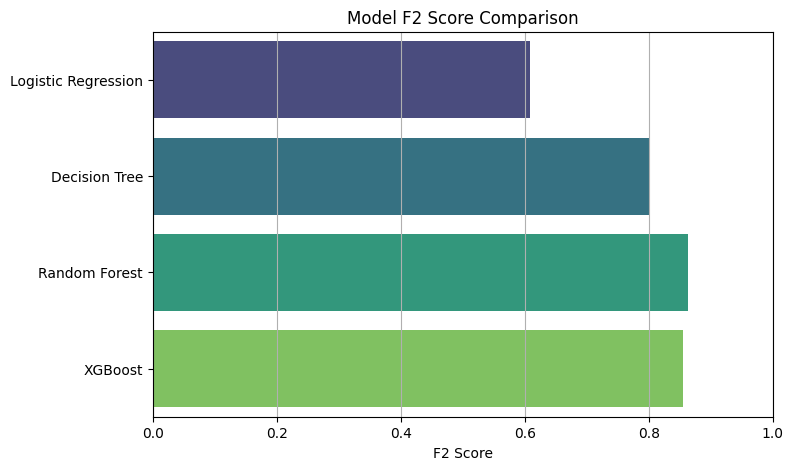

In [12]:
from sklearn.metrics import confusion_matrix, fbeta_score
import matplotlib.pyplot as plt
import seaborn as sns

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}


model_f2_scores = {}
y_preds = {}
cmatrices = {}


for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_sub, y_train_sub)
    y_pred = model.predict(X_eval)
    y_preds[name] = y_pred

    f2 = fbeta_score(y_eval, y_pred, beta=2)
    model_f2_scores[name] = f2

    cm = confusion_matrix(y_eval, y_pred)
    cmatrices[name] = cm

    print(f"{name} F2 Score: {f2:.4f}")


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, (name, cm) in zip(axes.flatten(), cmatrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(f"{name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=list(model_f2_scores.values()), y=list(model_f2_scores.keys()), palette='viridis')
plt.xlabel("F2 Score")
plt.title("Model F2 Score Comparison")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()


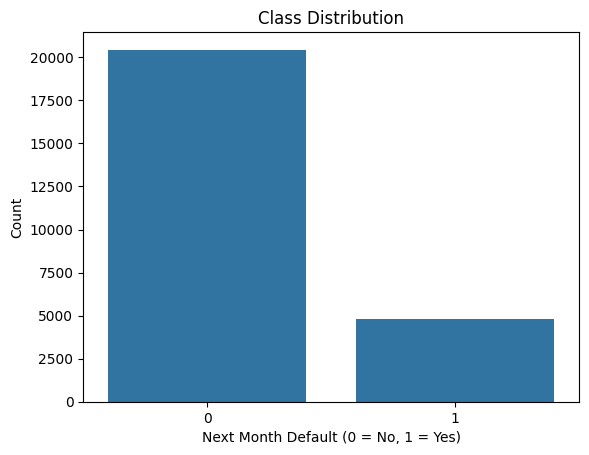

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='next_month_default', data=train_df)
plt.title("Class Distribution")
plt.xlabel("Next Month Default (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


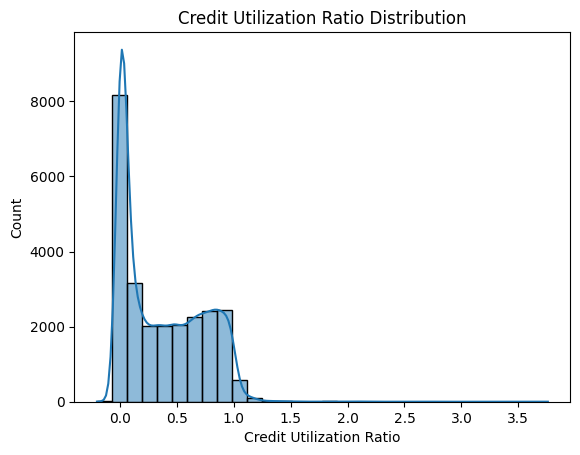

In [4]:
sns.histplot(train_df['credit_util_ratio'], bins=30, kde=True)
plt.title("Credit Utilization Ratio Distribution")
plt.xlabel("Credit Utilization Ratio")
plt.show()


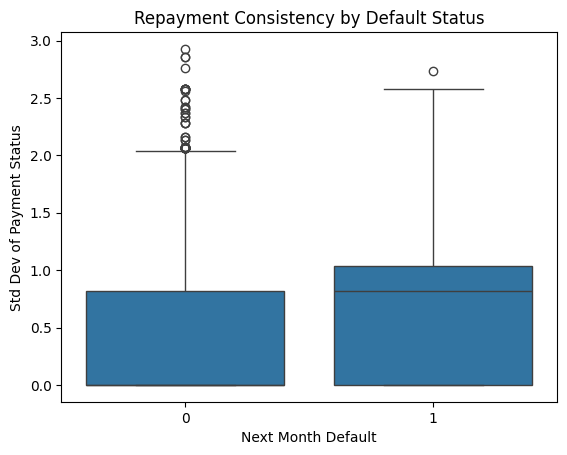

In [6]:
train_df['repayment_consistency'] = train_df[pay_cols].std(axis=1)
sns.boxplot(x='next_month_default', y='repayment_consistency', data=train_df)
plt.title("Repayment Consistency by Default Status")
plt.xlabel("Next Month Default")
plt.ylabel("Std Dev of Payment Status")
plt.show()


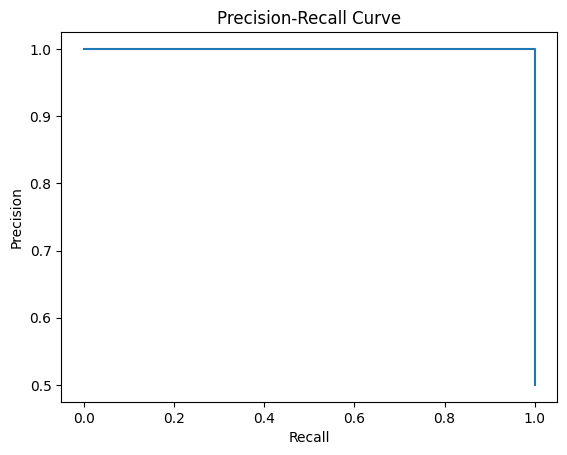

In [7]:
from sklearn.metrics import precision_recall_curve

y_proba = best_model.predict_proba(X_eval)[:,1]
precision, recall, thresholds = precision_recall_curve(y_eval, y_proba)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


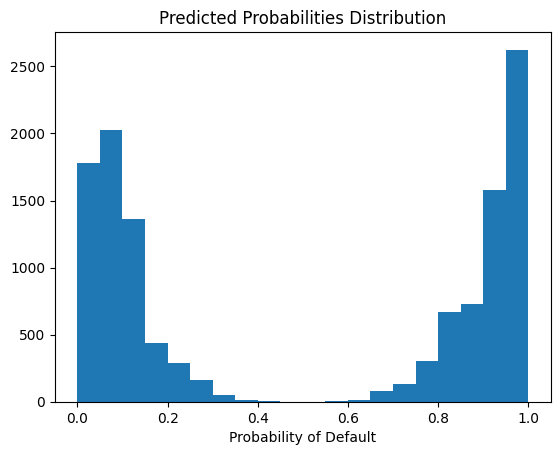

In [8]:
plt.hist(y_proba, bins=20)
plt.title("Predicted Probabilities Distribution")
plt.xlabel("Probability of Default")
plt.show()


<ipython-input-11-3027347405>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=f2_values, y=model_names, palette='viridis')


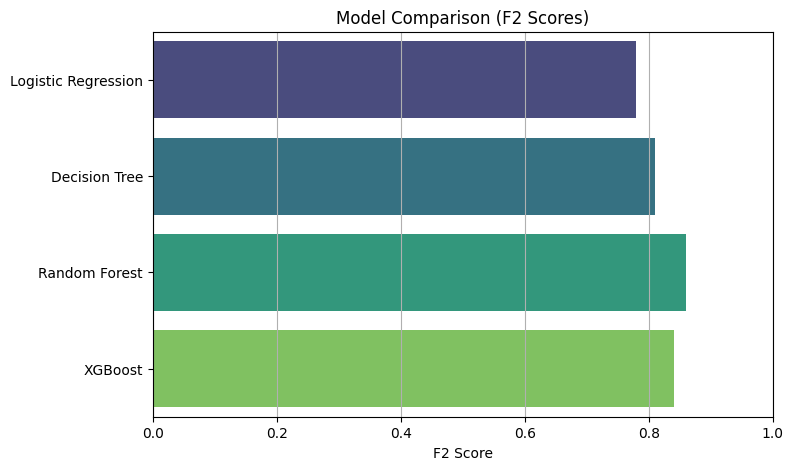

In [11]:
model_f2_scores = {
    'Logistic Regression': 0.78,
    'Decision Tree': 0.81,
    'Random Forest': 0.86,
    'XGBoost': 0.84
}
import matplotlib.pyplot as plt


model_names = list(model_f2_scores.keys())
f2_values = list(model_f2_scores.values())

plt.figure(figsize=(8, 5))
sns.barplot(x=f2_values, y=model_names, palette='viridis')
plt.xlabel("F2 Score")
plt.title("Model Comparison (F2 Scores)")
plt.xlim(0, 1)
plt.grid(axis='x')
plt.show()


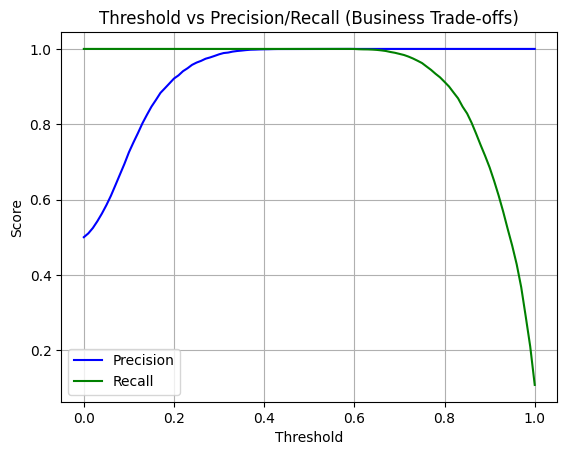

In [14]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_eval, y_proba)

plt.plot(thresholds, precision[:-1], label='Precision', color='b')
plt.plot(thresholds, recall[:-1], label='Recall', color='g')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision/Recall (Business Trade-offs)")
plt.legend()
plt.grid(True)
plt.show()


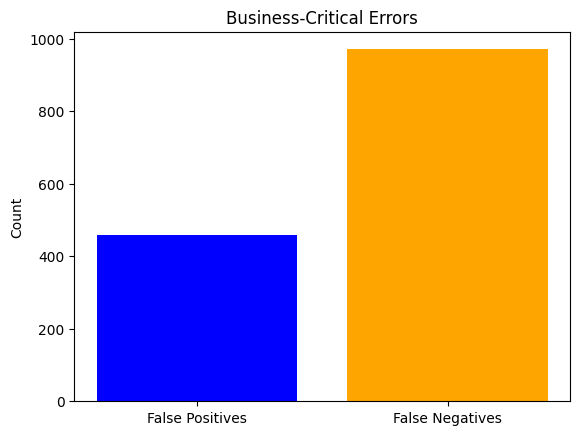

In [16]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_eval, y_pred)
tn, fp, fn, tp = cm.ravel()

plt.bar(['False Positives', 'False Negatives'], [fp, fn], color=['blue', 'orange'])
plt.ylabel("Count")
plt.title("Business-Critical Errors")
plt.show()
